In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install pytz

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

In [3]:
spy = yf.Ticker('SPY')
spy_data = spy.history(period='max')

# Fetch SPY dividend data
spy_dividends = spy.dividends
spy_dividends_df = spy_dividends.reset_index()
spy_dividends_df.columns = ['Date', 'Dividend']
spy_dividends_df['Date'] = pd.to_datetime(spy_dividends_df['Date'])

# Convert SPY data index to 'US/Eastern' timezone if it's not already
if spy_data.index.tzinfo is None:
    spy_data.index = spy_data.index.tz_localize('US/Eastern')
else:
    spy_data.index = spy_data.index.tz_convert('US/Eastern')

# Localize the dividend data if necessary
if spy_dividends.index.tzinfo is None:
    spy_dividends.index = spy_dividends.index.tz_localize('US/Eastern')
else:
    spy_dividends.index = spy_dividends.index.tz_convert('US/Eastern')

# Merge SPY data with dividend data
spy_data = pd.merge(spy_data.reset_index(), spy_dividends_df, left_on='Date', right_on='Date', how='left')

# Fill missing dividend values with 0
spy_data['Dividend'] = spy_data['Dividend'].fillna(0)

# Calculate normalized value
initial_investment = 10000
spy_data['normalized_value'] = float(initial_investment)

# Calculate normalized value
for i in range(1, len(spy_data)):
    dividend = spy_data.loc[spy_data.index[i], 'Dividend']
    price_today = spy_data.loc[spy_data.index[i], 'Close']
    price_yesterday = spy_data.loc[spy_data.index[i-1], 'Close']
    shares_today = spy_data.loc[spy_data.index[i-1], 'normalized_value'] / price_yesterday
    if dividend > 0:
        shares_today += (dividend / price_today)
    spy_data.loc[spy_data.index[i], 'normalized_value'] = float(shares_today * price_today)

print(spy_data.tail())

                          Date        Open        High         Low  \
7949 2024-08-26 00:00:00-04:00  563.179993  563.909973  559.049988   
7950 2024-08-27 00:00:00-04:00  559.489990  562.059998  558.320007   
7951 2024-08-28 00:00:00-04:00  561.210022  561.650024  555.039978   
7952 2024-08-29 00:00:00-04:00  560.309998  563.679993  557.179993   
7953 2024-08-30 00:00:00-04:00  560.770020  564.200012  557.140015   

           Close    Volume  Dividends  Stock Splits  Capital Gains  Dividend  \
7949  560.789978  35788600        0.0           0.0            0.0       0.0   
7950  561.559998  32693900        0.0           0.0            0.0       0.0   
7951  558.299988  41066000        0.0           0.0            0.0       0.0   
7952  558.349976  38715200        0.0           0.0            0.0       0.0   
7953  563.679993  62667800        0.0           0.0            0.0       0.0   

      normalized_value  
7949     227624.560392  
7950     227937.111194  
7951     226613.873763 

In [4]:
portfolio_div = ['PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW']

In [5]:
all_dividends = pd.DataFrame()

for symbol in portfolio_div:
    try:
        stock = yf.Ticker(symbol)

        # Fetch historical price data
        price_data = stock.history(start='1993-01-29', end='2023-12-31')
        price_data.reset_index(inplace=True)
        price_data['symbol'] = symbol  # Ensure 'symbol' column is in price_data

        # Fetch historical dividend data
        dividend_data = stock.dividends
        dividend_data.name = symbol
        dividend_data = dividend_data.reset_index()
        dividend_data.columns = ['Date', 'Dividend']
        dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
        dividend_data['symbol'] = symbol

        # Fetch historical stock splits data
        split_data = stock.splits
        split_data.name = 'Stock Splits'
        split_data = split_data.reset_index()
        split_data.columns = ['Date', 'Stock Splits']
        split_data['Date'] = pd.to_datetime(split_data['Date'])
        split_data['symbol'] = symbol

        # Merge price data and dividend data first
        combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date', 'symbol'])

        # Check if split_data is empty before merging
        if not split_data.empty:
            combined_data = pd.merge(combined_data, split_data, how='left', on=['Date', 'symbol'])
        else:
            # If no splits, add Stock Splits column with NaNs
            combined_data['Stock Splits'] = np.nan

        # Adjust historical prices and dividends for stock splits if splits data exists
        if 'Stock Splits' in combined_data.columns:
            combined_data['Adj Close'] = combined_data['Close']
            combined_data['Adj Dividend'] = combined_data['Dividend']

            for i in range(1, len(combined_data)):
                if pd.notna(combined_data.at[i, 'Stock Splits']) and combined_data.at[i, 'Stock Splits'] != 0:
                    ratio = combined_data.at[i, 'Stock Splits']
                    combined_data.loc[:i-1, 'Adj Close'] /= ratio
                    combined_data.loc[:i-1, 'Adj Dividend'] /= ratio

        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")

# After merging dataframes, clean up column names if necessary
if 'Stock Splits_x' in all_dividends.columns and 'Stock Splits_y' in all_dividends.columns:
    all_dividends.rename(columns={'Stock Splits_x': 'Stock Splits Price', 'Stock Splits_y': 'Stock Splits Dividend'}, inplace=True)
    # Drop one if not needed
    all_dividends.drop(columns=['Stock Splits Dividend'], inplace=True)

print(all_dividends.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits Price', 'symbol', 'Dividend', 'Stock Splits', 'Adj Close',
       'Adj Dividend'],
      dtype='object')


In [6]:
print(all_dividends.head())

                       Date      Open      High       Low     Close   Volume  \
0 1993-01-29 00:00:00-05:00  5.788132  5.802530  5.716140  5.730538  4040000   
1 1993-02-01 00:00:00-05:00  5.759334  5.802529  5.730537  5.788130  3292400   
2 1993-02-02 00:00:00-05:00  5.759338  5.816931  5.759338  5.759338  2364400   
3 1993-02-03 00:00:00-05:00  5.788133  5.845727  5.788133  5.831328  2091600   
4 1993-02-04 00:00:00-05:00  5.860125  5.888921  5.802531  5.860125  3082800   

   Dividends  Stock Splits Price symbol  Dividend  Stock Splits  Adj Close  \
0        0.0                 0.0     PG       NaN           NaN        NaN   
1        0.0                 0.0     PG       NaN           NaN        NaN   
2        0.0                 0.0     PG       NaN           NaN        NaN   
3        0.0                 0.0     PG       NaN           NaN        NaN   
4        0.0                 0.0     PG       NaN           NaN        NaN   

   Adj Dividend  
0           NaN  
1           Na

In [7]:
portfolio_div = ['PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW']

all_dividends = pd.DataFrame()

for symbol in portfolio_div:
    try:
        stock = yf.Ticker(symbol)

        # Fetch historical price data
        price_data = stock.history(start='1993-01-29', end='2023-12-31')
        price_data.reset_index(inplace=True)
        price_data['symbol'] = symbol  # Ensure 'symbol' column is in price_data

        # Fetch historical dividend data
        dividend_data = stock.dividends
        dividend_data.name = symbol
        dividend_data = dividend_data.reset_index()
        dividend_data.columns = ['Date', 'Dividend']
        dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
        dividend_data['symbol'] = symbol

        # Fetch historical stock splits data
        split_data = stock.splits
        split_data.name = 'Stock Splits'
        split_data = split_data.reset_index()
        split_data.columns = ['Date', 'Stock Splits']
        split_data['Date'] = pd.to_datetime(split_data['Date'])
        split_data['symbol'] = symbol

        # Merge price data and dividend data first
        combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date', 'symbol'])

        # Merge stock splits data
        if not split_data.empty:
            combined_data = pd.merge(combined_data, split_data, how='left', on=['Date', 'symbol'])
        else:
            # If no splits, add Stock Splits column with NaNs
            combined_data['Stock Splits'] = np.nan

        # Adjust historical prices and dividends for stock splits if splits data exists
        if 'Stock Splits' in combined_data.columns:
            combined_data['Adj Close'] = combined_data['Close']
            combined_data['Adj Dividend'] = combined_data['Dividend']

            for i in range(1, len(combined_data)):
                if pd.notna(combined_data.at[i, 'Stock Splits']) and combined_data.at[i, 'Stock Splits'] != 0:
                    ratio = combined_data.at[i, 'Stock Splits']
                    combined_data.loc[:i-1, 'Adj Close'] /= ratio
                    combined_data.loc[:i-1, 'Adj Dividend'] /= ratio

        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")

# Ensure the 'Date' column is in datetime format
all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])

# Ensure column cleanup after merges
if 'Stock Splits_x' in all_dividends.columns and 'Stock Splits_y' in all_dividends.columns:
    all_dividends.rename(columns={'Stock Splits_x': 'Stock Splits Price', 'Stock Splits_y': 'Stock Splits Dividend'}, inplace=True)
    # Drop one if not needed
    all_dividends.drop(columns=['Stock Splits Dividend'], inplace=True)

# Adding DRIP logic
dripped_symbols = {'PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW'}
all_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')

# Calculate reinvested dividends
all_dividends['Reinvested_Dividends'] = all_dividends.apply(
    lambda row: row['Dividend'] if row['DRIP'] == 'yes' else 0, axis=1
)

# Calculate additional shares purchased from reinvested dividends
all_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Close']

# Calculate cumulative total shares for each stock symbol
all_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()

# Initial investment assumption (adjust as needed)
initial_investment = 10000

# Calculate initial shares bought with initial investment
all_dividends['Initial_Shares'] = initial_investment / all_dividends.groupby('symbol')['Close'].transform('first')

# Calculate the portfolio value
all_dividends['Portfolio_Value'] = all_dividends['Initial_Shares'] * all_dividends['Close'] + all_dividends['Total_Shares'] * all_dividends['Close']

print(all_dividends.head())

                       Date      Open      High       Low     Close   Volume  \
0 1993-01-29 00:00:00-05:00  5.788132  5.802530  5.716140  5.730538  4040000   
1 1993-02-01 00:00:00-05:00  5.759334  5.802529  5.730537  5.788130  3292400   
2 1993-02-02 00:00:00-05:00  5.759338  5.816931  5.759338  5.759338  2364400   
3 1993-02-03 00:00:00-05:00  5.788133  5.845727  5.788133  5.831328  2091600   
4 1993-02-04 00:00:00-05:00  5.860125  5.888921  5.802531  5.860125  3082800   

   Dividends  Stock Splits Price symbol  Dividend  Stock Splits  Adj Close  \
0        0.0                 0.0     PG       NaN           NaN        NaN   
1        0.0                 0.0     PG       NaN           NaN        NaN   
2        0.0                 0.0     PG       NaN           NaN        NaN   
3        0.0                 0.0     PG       NaN           NaN        NaN   
4        0.0                 0.0     PG       NaN           NaN        NaN   

   Adj Dividend DRIP  Reinvested_Dividends  Additi

In [8]:
'''# List of dividend portfolio tickers
portfolio_div = ['PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW']


all_dividends = pd.DataFrame()


for symbol in portfolio_div:
    try:
        dividend_data = yf.download(symbol, start='1993-01-29', end='2023-12-31')
        dividend_data['symbol'] = symbol

        all_dividends = pd.concat([all_dividends, dividend_data], ignore_index=False)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")

# Reset the index to have date as a column for easier filtering
all_dividends.reset_index(inplace=True)

# Display the first few rows of the combined dividend data
print(all_dividends.head())'''

'# List of dividend portfolio tickers\nportfolio_div = [\'PG\', \'GPC\', \'EMR\', \'CINF\', \'KO\', \'CL\', \'MO\', \'FRT\', \'PPG\', \'TROW\']\n\n\nall_dividends = pd.DataFrame()\n\n\nfor symbol in portfolio_div:\n    try:\n        dividend_data = yf.download(symbol, start=\'1993-01-29\', end=\'2023-12-31\')\n        dividend_data[\'symbol\'] = symbol\n\n        all_dividends = pd.concat([all_dividends, dividend_data], ignore_index=False)\n\n    except Exception as e:\n        print(f"Failed to get data for {symbol}: {e}")\n\n# Reset the index to have date as a column for easier filtering\nall_dividends.reset_index(inplace=True)\n\n# Display the first few rows of the combined dividend data\nprint(all_dividends.head())'

In [9]:
'''all_dividends = pd.DataFrame()

for symbol in portfolio_div:
    try:
        stock = yf.Ticker(symbol)
        # Fetch historical price data
        price_data = stock.history(start='1993-01-29', end='2023-12-31')
        price_data.reset_index(inplace=True)

        # Fetch historical dividend data
        dividend_data = stock.dividends
        dividend_data.name = symbol
        dividend_data = dividend_data.reset_index()
        dividend_data.columns = ['Date', 'Dividend']
        dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
        dividend_data['symbol'] = symbol

        # Merge dividend data with price data
        combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date'])
        combined_data['symbol'] = symbol

        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")


all_dividends = all_dividends.drop(columns = ['Dividend'])
print(all_dividends.head())

print(all_dividends.columns)


all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])

print(all_dividends.dtypes)
'''


'all_dividends = pd.DataFrame()\n\nfor symbol in portfolio_div:\n    try:\n        stock = yf.Ticker(symbol)\n        # Fetch historical price data\n        price_data = stock.history(start=\'1993-01-29\', end=\'2023-12-31\')\n        price_data.reset_index(inplace=True)\n\n        # Fetch historical dividend data\n        dividend_data = stock.dividends\n        dividend_data.name = symbol\n        dividend_data = dividend_data.reset_index()\n        dividend_data.columns = [\'Date\', \'Dividend\']\n        dividend_data[\'Date\'] = pd.to_datetime(dividend_data[\'Date\'])\n        dividend_data[\'symbol\'] = symbol\n\n        # Merge dividend data with price data\n        combined_data = pd.merge(price_data, dividend_data, how=\'left\', on=[\'Date\'])\n        combined_data[\'symbol\'] = symbol\n\n        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)\n\n    except Exception as e:\n        print(f"Failed to get data for {symbol}: {e}")\n\n\nall_dividends 

In [10]:
'''dripped_symbols = {'PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW'}
all_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')'''

"dripped_symbols = {'PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW'}\nall_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')"

In [11]:
'''all_dividends['Reinvested_Dividends'] = all_dividends.apply(
    lambda row: row['Dividends'] if row['DRIP'] == 'yes' else 0, axis=1
)

all_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Close']

# Accumulate total shares over time
all_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()

initial_investment = 10000

initial_shares = initial_investment / all_dividends['Close'].iloc[0]

# Calculate the portfolio value
all_dividends['Portfolio_Value'] = initial_shares * all_dividends['Close'] + all_dividends['Total_Shares'] * all_dividends['Close']

print(all_dividends.head())'''

"all_dividends['Reinvested_Dividends'] = all_dividends.apply(\n    lambda row: row['Dividends'] if row['DRIP'] == 'yes' else 0, axis=1\n)\n\nall_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Close']\n\n# Accumulate total shares over time\nall_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()\n\ninitial_investment = 10000\n\ninitial_shares = initial_investment / all_dividends['Close'].iloc[0]\n\n# Calculate the portfolio value\nall_dividends['Portfolio_Value'] = initial_shares * all_dividends['Close'] + all_dividends['Total_Shares'] * all_dividends['Close']\n\nprint(all_dividends.head())"

In [12]:
ko = yf.Ticker("KO")
split_data = ko.splits
print(split_data)

Date
1965-02-19 00:00:00-05:00    2.0
1968-06-03 00:00:00-04:00    2.0
1977-06-01 00:00:00-04:00    2.0
1986-07-01 00:00:00-04:00    3.0
1990-05-14 00:00:00-04:00    2.0
1992-05-12 00:00:00-04:00    2.0
1996-05-13 00:00:00-04:00    2.0
2012-08-13 00:00:00-04:00    2.0
Name: Stock Splits, dtype: float64


In [13]:
# Initialize an empty DataFrame
all_dividends = pd.DataFrame()

# Define the portfolio symbols
portfolio_div = ['PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW']

# Fetch data for each symbol
for symbol in portfolio_div:
    try:
        stock = yf.Ticker(symbol)

        # Fetch historical price data
        price_data = stock.history(start='1993-01-29', end='2023-12-31')
        price_data.reset_index(inplace=True)

        # Fetch historical dividend data
        dividend_data = stock.dividends
        dividend_data = dividend_data.reset_index()
        dividend_data.columns = ['Date', 'Dividend']
        dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
        dividend_data['symbol'] = symbol

        # Fetch historical stock split data
        stock_splits = stock.splits
        stock_splits = stock_splits.reset_index()
        stock_splits.columns = ['Date', 'Stock_Split']
        stock_splits['Date'] = pd.to_datetime(stock_splits['Date'])
        stock_splits['symbol'] = symbol

        # Merge price, dividend, and stock split data
        combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date'])
        combined_data = pd.merge(combined_data, stock_splits, how='left', on=['Date'])
        combined_data['symbol'] = symbol

        # Append to all_dividends DataFrame
        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")

# Reset index and handle missing columns
all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])
all_dividends.set_index('Date', inplace=True)
all_dividends['Date_as_Index'] = all_dividends.index
all_dividends.reset_index(inplace=True)
all_dividends.set_index('Date_as_Index', inplace=True)

# Check the DataFrame
print(all_dividends.head())
print(all_dividends.columns)
print(all_dividends.index)

                                               Date      Open      High  \
Date_as_Index                                                             
1993-01-29 00:00:00-05:00 1993-01-29 00:00:00-05:00  5.788132  5.802530   
1993-02-01 00:00:00-05:00 1993-02-01 00:00:00-05:00  5.759334  5.802529   
1993-02-02 00:00:00-05:00 1993-02-02 00:00:00-05:00  5.759338  5.816931   
1993-02-03 00:00:00-05:00 1993-02-03 00:00:00-05:00  5.788133  5.845727   
1993-02-04 00:00:00-05:00 1993-02-04 00:00:00-05:00  5.860125  5.888921   

                                Low     Close   Volume  Dividends  \
Date_as_Index                                                       
1993-01-29 00:00:00-05:00  5.716140  5.730538  4040000        0.0   
1993-02-01 00:00:00-05:00  5.730537  5.788130  3292400        0.0   
1993-02-02 00:00:00-05:00  5.759338  5.759338  2364400        0.0   
1993-02-03 00:00:00-05:00  5.788133  5.831328  2091600        0.0   
1993-02-04 00:00:00-05:00  5.802531  5.860125  3082800      

In [14]:
print(all_dividends.isna().sum())

Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Dividends           0
Stock Splits        0
Dividend        76612
symbol_x        76612
Stock_Split     77838
symbol_y        77838
symbol              0
dtype: int64


In [15]:
# Define DRIP symbols
dripped_symbols = {'PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW'}

# Add DRIP column
all_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')

# Calculate reinvested dividends and additional shares
all_dividends['Reinvested_Dividends'] = all_dividends.apply(
    lambda row: row['Dividends'] if row['DRIP'] == 'yes' else 0, axis=1
)

# Adjust for stock splits
all_dividends['Adjusted_Close'] = all_dividends.groupby('symbol')['Close'].apply(
    lambda x: x / x.shift(1).fillna(1)  # Adjust for previous day’s splits
)

# Calculate additional shares
all_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Adjusted_Close']

# Accumulate total shares over time
all_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()

# Calculate initial shares and portfolio value
initial_investment = 10000
initial_shares = initial_investment / all_dividends['Close'].iloc[0]
all_dividends['Portfolio_Value'] = initial_shares * all_dividends['Close'] + all_dividends['Total_Shares'] * all_dividends['Close']

print(all_dividends.head())

if all_dividends.index.tzinfo is None:
    all_dividends.index = all_dividends.index.tz_localize('US/Eastern')
else:
    all_dividends.index = all_dividends.index.tz_convert('US/Eastern')

                                               Date      Open      High  \
Date_as_Index                                                             
1993-01-29 00:00:00-05:00 1993-01-29 00:00:00-05:00  5.788132  5.802530   
1993-02-01 00:00:00-05:00 1993-02-01 00:00:00-05:00  5.759334  5.802529   
1993-02-02 00:00:00-05:00 1993-02-02 00:00:00-05:00  5.759338  5.816931   
1993-02-03 00:00:00-05:00 1993-02-03 00:00:00-05:00  5.788133  5.845727   
1993-02-04 00:00:00-05:00 1993-02-04 00:00:00-05:00  5.860125  5.888921   

                                Low     Close   Volume  Dividends  \
Date_as_Index                                                       
1993-01-29 00:00:00-05:00  5.716140  5.730538  4040000        0.0   
1993-02-01 00:00:00-05:00  5.730537  5.788130  3292400        0.0   
1993-02-02 00:00:00-05:00  5.759338  5.759338  2364400        0.0   
1993-02-03 00:00:00-05:00  5.788133  5.831328  2091600        0.0   
1993-02-04 00:00:00-05:00  5.802531  5.860125  3082800      

In [16]:
print(spy_data.head())

print(spy_data.tail())

print(all_dividends.head())

print(all_dividends.tail())

print(spy_data.info())

print(all_dividends.info())

print(spy_data.isnull().sum())

print(all_dividends.isnull().sum())

print(all_dividends.columns)

                       Date       Open       High        Low      Close  \
0 1993-01-29 00:00:00-05:00  24.701661  24.701661  24.578767  24.684105   
1 1993-02-01 00:00:00-05:00  24.701659  24.859665  24.701659  24.859665   
2 1993-02-02 00:00:00-05:00  24.842113  24.929895  24.789444  24.912338   
3 1993-02-03 00:00:00-05:00  24.947458  25.193246  24.929902  25.175690   
4 1993-02-04 00:00:00-05:00  25.263465  25.333690  24.982565  25.281021   

    Volume  Dividends  Stock Splits  Capital Gains  Dividend  normalized_value  
0  1003200        0.0           0.0            0.0       0.0      10000.000000  
1   480500        0.0           0.0            0.0       0.0      10071.122691  
2   201300        0.0           0.0            0.0       0.0      10092.461662  
3   529400        0.0           0.0            0.0       0.0      10199.150336  
4   531500        0.0           0.0            0.0       0.0      10241.822096  
                          Date        Open        High         

In [17]:
spy_data.reset_index(inplace=True)
if 'Date' in spy_data.columns:
    spy_data['Date'] = pd.to_datetime(spy_data['Date'])

    spy_data.set_index('Date', inplace=True)
else:
    print("No 'Date' column found in spy_data.")
print(spy_data.index)

DatetimeIndex(['1993-01-29 00:00:00-05:00', '1993-02-01 00:00:00-05:00',
               '1993-02-02 00:00:00-05:00', '1993-02-03 00:00:00-05:00',
               '1993-02-04 00:00:00-05:00', '1993-02-05 00:00:00-05:00',
               '1993-02-08 00:00:00-05:00', '1993-02-09 00:00:00-05:00',
               '1993-02-10 00:00:00-05:00', '1993-02-11 00:00:00-05:00',
               ...
               '2024-08-19 00:00:00-04:00', '2024-08-20 00:00:00-04:00',
               '2024-08-21 00:00:00-04:00', '2024-08-22 00:00:00-04:00',
               '2024-08-23 00:00:00-04:00', '2024-08-26 00:00:00-04:00',
               '2024-08-27 00:00:00-04:00', '2024-08-28 00:00:00-04:00',
               '2024-08-29 00:00:00-04:00', '2024-08-30 00:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Date', length=7954, freq=None)


In [18]:
print(all_dividends.index)

DatetimeIndex(['1993-01-29 00:00:00-05:00', '1993-02-01 00:00:00-05:00',
               '1993-02-02 00:00:00-05:00', '1993-02-03 00:00:00-05:00',
               '1993-02-04 00:00:00-05:00', '1993-02-05 00:00:00-05:00',
               '1993-02-08 00:00:00-05:00', '1993-02-09 00:00:00-05:00',
               '1993-02-10 00:00:00-05:00', '1993-02-11 00:00:00-05:00',
               ...
               '2023-12-15 00:00:00-05:00', '2023-12-18 00:00:00-05:00',
               '2023-12-19 00:00:00-05:00', '2023-12-20 00:00:00-05:00',
               '2023-12-21 00:00:00-05:00', '2023-12-22 00:00:00-05:00',
               '2023-12-26 00:00:00-05:00', '2023-12-27 00:00:00-05:00',
               '2023-12-28 00:00:00-05:00', '2023-12-29 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', name='Date_as_Index', length=77860, freq=None)


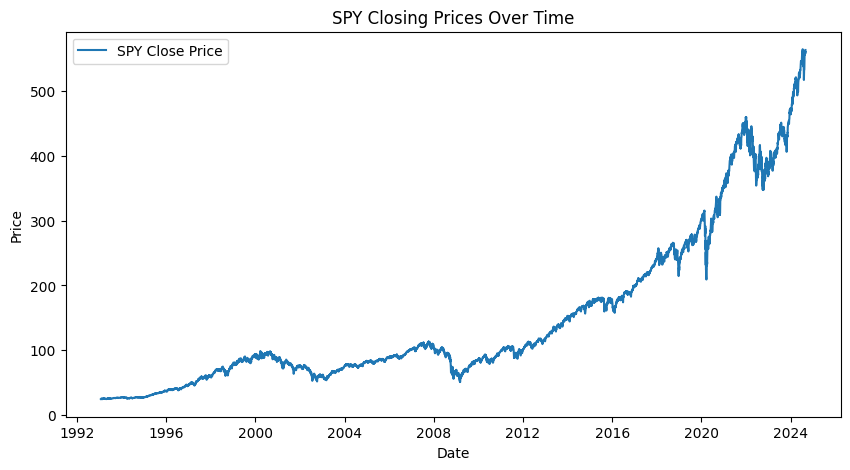

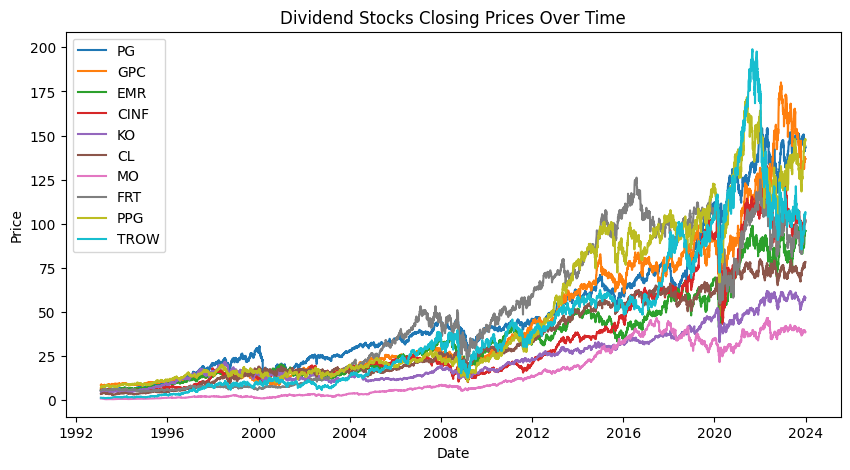

In [19]:
# Plot SPY closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(spy_data['Close'], label='SPY Close Price')
plt.title('SPY Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot closing prices for the dividend stocks
plt.figure(figsize=(10, 5))
for symbol in all_dividends['symbol'].unique():
    plt.plot(all_dividends[all_dividends['symbol'] == symbol]['Date'],
             all_dividends[all_dividends['symbol'] == symbol]['Close'], label=symbol)

plt.title('Dividend Stocks Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Group by 'date' and calculate the mean 'Close' price for each date
daily_dividend_prices = all_dividends.groupby('Date')['Close'].mean()

# Convert to DataFrame for easier manipulation
dividend_prices_df = daily_dividend_prices.reset_index()

In [21]:
# Normalize SPY data to $10,000
initial_investment = 10000
spy_data['normalized_value'] = initial_investment * (spy_data['Close'] / spy_data['Close'].iloc[0])


In [22]:
# Normalize Dividend data to $10,000
dividend_initial_investment = 10000
dividend_prices_df['normalized_value'] = dividend_initial_investment * (dividend_prices_df['Close'] / dividend_prices_df['Close'].iloc[0])




In [23]:
print(spy_data.index)
print(all_dividends.index)

DatetimeIndex(['1993-01-29 00:00:00-05:00', '1993-02-01 00:00:00-05:00',
               '1993-02-02 00:00:00-05:00', '1993-02-03 00:00:00-05:00',
               '1993-02-04 00:00:00-05:00', '1993-02-05 00:00:00-05:00',
               '1993-02-08 00:00:00-05:00', '1993-02-09 00:00:00-05:00',
               '1993-02-10 00:00:00-05:00', '1993-02-11 00:00:00-05:00',
               ...
               '2024-08-19 00:00:00-04:00', '2024-08-20 00:00:00-04:00',
               '2024-08-21 00:00:00-04:00', '2024-08-22 00:00:00-04:00',
               '2024-08-23 00:00:00-04:00', '2024-08-26 00:00:00-04:00',
               '2024-08-27 00:00:00-04:00', '2024-08-28 00:00:00-04:00',
               '2024-08-29 00:00:00-04:00', '2024-08-30 00:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Date', length=7954, freq=None)
DatetimeIndex(['1993-01-29 00:00:00-05:00', '1993-02-01 00:00:00-05:00',
               '1993-02-02 00:00:00-05:00', '1993-02-03 00:00:00-05:00',
               '1

In [24]:
print(all_dividends.index.duplicated().sum())
print(spy_data.index.duplicated().sum())

70074
0


In [25]:
all_dividends = all_dividends[~all_dividends.index.duplicated(keep='first')]
spy_data = spy_data[~spy_data.index.duplicated(keep='first')]
all_dividends['Close'] = pd.to_numeric(all_dividends['Close'], errors='coerce')
all_dividends = all_dividends.dropna(subset=['Close'])


<ipython-input-25-39cf1a4ae6ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dividends['Close'] = pd.to_numeric(all_dividends['Close'], errors='coerce')


In [38]:
all_dividends['Reinvested_Dividends'] = pd.to_numeric(all_dividends['Reinvested_Dividends'], errors='coerce')
all_dividends['Additional_Shares'] = pd.to_numeric(all_dividends['Additional_Shares'], errors='coerce')
all_dividends['Total_Shares'] = pd.to_numeric(all_dividends['Total_Shares'], errors='coerce')
all_dividends['Portfolio_Value'] = pd.to_numeric(all_dividends['Portfolio_Value'], errors='coerce')

all_dividends = all_dividends.dropna(subset=['Close', 'Reinvested_Dividends', 'Additional_Shares', 'Total_Shares', 'Portfolio_Value'])

all_dividends = all_dividends[~all_dividends.index.duplicated(keep='first')]


print(all_dividends.dtypes)

Date                    datetime64[ns, America/New_York]
Open                                             float64
High                                             float64
Low                                              float64
Close                                            float64
Volume                                             int64
Dividends                                        float64
Stock Splits                                     float64
Dividend                                         float64
symbol_x                                          object
Stock_Split                                      float64
symbol_y                                          object
symbol                                            object
DRIP                                              object
Reinvested_Dividends                             float64
Adjusted_Close                                   float64
Additional_Shares                                float64
Total_Shares                   

In [39]:
numeric_cols = ['Close', 'Reinvested_Dividends', 'Additional_Shares', 'Total_Shares', 'Portfolio_Value']
all_dividends_numeric = all_dividends[numeric_cols]

all_dividends_numeric = all_dividends_numeric.resample('D').mean()



# Check if DataFrame is not empty
if not all_dividends_numeric.empty:
    # Normalize values
    all_dividends_numeric['normalized_value'] = (all_dividends_numeric['Close'] / all_dividends_numeric['Close'].iloc[0]) * 10000
else:
    print("all_dividends_numeric is empty after resampling.")

all_dividends_numeric is empty after resampling.


In [32]:
all_dividends_non_numeric = all_dividends[['DRIP', 'symbol']].resample('D').first()
all_dividends_clean = pd.concat([all_dividends_numeric, all_dividends_non_numeric], axis=1)

In [33]:
print(all_dividends_clean.dtypes)

Close                   float64
Reinvested_Dividends    float64
Additional_Shares       float64
Total_Shares            float64
Portfolio_Value         float64
DRIP                     object
symbol                   object
dtype: object


In [36]:
# Check if DataFrame is not empty before normalizing
if not all_dividends.empty:
    all_dividends_clean['normalized_value'] = (all_dividends['Close'] / all_dividends['Close'].iloc[0]) * 10000
else:
    print("all_dividends is empty, cannot calculate normalized_value.")

# Proceed with normalizing spy_data as before
spy_data['normalized_value'] = (spy_data['Close'] / spy_data['Close'].iloc[0]) * 10000

start_date = max(all_dividends.index.min(), spy_data.index.min())
end_date = min(all_dividends.index.max(), spy_data.index.max())

all_dividends = all_dividends[start_date:end_date]
spy_data = spy_data[start_date:end_date]

all_dividends is empty, cannot calculate normalized_value.


In [37]:
plt.figure(figsize=(14, 7))
plt.plot(all_dividends_clean.index, all_dividends_clean['normalized_value'], label='Dividend Portfolio', color='green')
plt.plot(spy_data.index, spy_data['normalized_value'], label='SPY Growth Portfolio', color='blue')
plt.title('Performance Comparison: Growth vs Dividend Portfolio')
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value ($10,000 Initial)')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'normalized_value'

<Figure size 1400x700 with 0 Axes>